# Starbucks Capstone Challenge - Data Understanding

## Setup

In [1]:
import sys

!{sys.executable} -m pip install -e ../ --quiet

ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: C:\ProgramData\scoop\apps\vscode


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sb_capstone.wrangling import (
    clean_portfolio, 
    clean_profile, 
    clean_transcript,
    s3_remove_outliers,
    ChannelType
)

%matplotlib inline

np.set_printoptions(suppress=True)
base_color = sns.color_palette()[0]

In [3]:
portfolio = pd.read_csv("../data/processed/portfolio.csv")
portfolio = clean_portfolio(portfolio)
portfolio.head()

,id,offer_type,channels,reward,difficulty,duration
0,1,bogo,"[email, mobile, social]",10,10,7
1,2,bogo,"[web, email, mobile, social]",10,10,5
2,3,informational,"[web, email, mobile]",0,0,4
3,4,bogo,"[web, email, mobile]",5,5,7
4,5,discount,"[web, email]",5,20,10


In [4]:
profile = pd.read_csv("../data/processed/profile.csv")
profile = clean_profile(profile)
profile.head()

,id,gender,age,income,became_member_on
0,1,NaN,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,NaN,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,NaN,NaN,NaN,2017-08-04


In [5]:
transcript = pd.read_csv("../data/processed/transcript.csv")
transcript = clean_transcript(transcript)
transcript.head()

,person_id,event,time,offer_id,amount,reward
0,4,offer_received,0,4,NaN,NaN
1,4,offer_viewed,6,4,NaN,NaN
2,4,transaction,132,0,19.89,NaN
3,4,offer_completed,132,4,NaN,5.0
4,4,transaction,144,0,17.78,NaN


## Data Analysis

### Understand Portfolio Table

The `portfolio` table contains the offers and its details. This section aims to understand how it is setup and how conservative the setup are. We're going to look at if there are any relationship with regards to the rewards and difficulty with duration. We're going to see as well if there are any patterns in the data.

#### Univariate

In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          10 non-null     int64   
 1   offer_type  10 non-null     category
 2   channels    10 non-null     object  
 3   reward      10 non-null     int64   
 4   difficulty  10 non-null     int64   
 5   duration    10 non-null     int64   
dtypes: category(1), int64(4), object(1)
memory usage: 670.0+ bytes


Only `10` offers made. No missing values.

Since there are only ten items. We can perform visual inspection to the whole data and observe any patterns. We sorted by `duration`, `difficulty`, and `reward`.

In [7]:
portfolio.sort_values(by=["duration", "difficulty", "reward"], ascending=False)

,id,offer_type,channels,reward,difficulty,duration
4,5,discount,"[web, email]",5,20,10
6,7,discount,"[web, email, mobile, social]",2,10,10
0,1,bogo,"[email, mobile, social]",10,10,7
9,10,discount,"[web, email, mobile]",2,10,7
5,6,discount,"[web, email, mobile, social]",3,7,7
3,4,bogo,"[web, email, mobile]",5,5,7
1,2,bogo,"[web, email, mobile, social]",10,10,5
8,9,bogo,"[web, email, mobile, social]",5,5,5
2,3,informational,"[web, email, mobile]",0,0,4
7,8,informational,"[email, mobile, social]",0,0,3


Buy-One-Get-One (`bogo`) offer has the same `reward` and difficulty. Combinations varies and a bit conservative except for `bogo`. The `portfolio` table's most expensive visually are the `bogo` offers while the cheapest ones are the `informational` types.

Next, is let's try to describe the `portfolio` table see if there are any glaring patterns.

In [8]:
portfolio.describe(include="all")

,id,offer_type,channels,reward,difficulty,duration
count,10.00000,10,10,10.000000,10.000000,10.000000
unique,NaN,3,4,NaN,NaN,NaN
top,NaN,bogo,"[web, email, mobile, social]",NaN,NaN,NaN
freq,NaN,4,4,NaN,NaN,NaN
mean,5.50000,NaN,NaN,4.200000,7.700000,6.500000
std,3.02765,NaN,NaN,3.583915,5.831905,2.321398
min,1.00000,NaN,NaN,0.000000,0.000000,3.000000
25%,3.25000,NaN,NaN,2.000000,5.000000,5.000000
50%,5.50000,NaN,NaN,4.000000,8.500000,7.000000
75%,7.75000,NaN,NaN,5.000000,10.000000,7.000000


A few notable items here:

* Rewards are up to 10 and difficulty is up to 20. Perhaps this make sense, as the price of coffee would probably on that range.
* Top channel used includes all media (`web`, `email`, `mobile`, `social`)

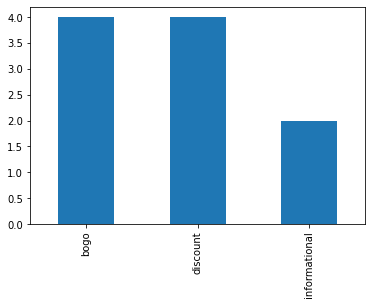

In [9]:
portfolio.offer_type.value_counts().plot(kind="bar");

Balance distribution of different offer types, 4 `bogo` and `discount` offer types and 2 `informational`.

Next we'll look at the different channels and how are they distributed.

In [10]:
portfolio.channels.explode().astype(ChannelType).value_counts()

email     10
mobile     9
web        8
social     6
Name: channels, dtype: int64

`email` and `mobile` tops the list.

#### Bivariate and Multivariate

Let's look at which offer in the portfolio table is the most expensive and the cheapest.

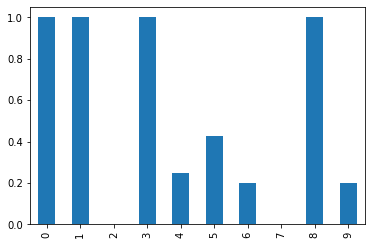

In [11]:
portfolio_price = portfolio.copy()

portfolio_price["reward_pct"] = (portfolio_price.reward/portfolio_price.difficulty).fillna(0)
portfolio_price.reward_pct.plot(kind="bar");

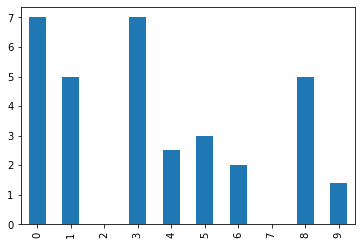

In [12]:
portfolio_price["reward_ot"] = portfolio_price.reward_pct * portfolio_price.duration
portfolio_price.reward_ot.plot(kind="bar");

`bogo` offers are of course the more expensive ones. When we add duration, `bogo` offers are still the most expensive and we can see as well which one stands out as they are ran longer.

We also don't have a price tag on how expensive each channels are, but we can perhaps pull out which one are used mostly with aspect of duration.

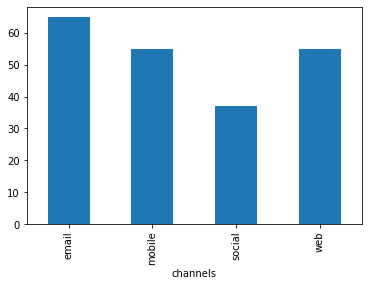

In [13]:
portfolio_price \
    .explode(column="channels") \
    .groupby("channels") \
    .duration \
    .sum() \
    .plot(kind="bar");

`email` is the most used channel based on duration. This may tell us story on which channel is easier/cheaper to implement.

### Understand Profile Table

Profile contains short description of customers under study. We'll try to understand types of customers we are trying to study.

Let's look first what data are available and some summary.

#### Univariate

In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                17000 non-null  int64         
 1   gender            14825 non-null  category      
 2   age               14825 non-null  float64       
 3   income            14825 non-null  float64       
 4   became_member_on  17000 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(2), int64(1)
memory usage: 548.1 KB


In [15]:
profile.describe(include="all", datetime_is_numeric=True)

,id,gender,age,income,became_member_on
count,17000.000000,14825,14825.000000,14825.000000,17000
unique,NaN,3,NaN,NaN,NaN
top,NaN,M,NaN,NaN,NaN
freq,NaN,8484,NaN,NaN,NaN
mean,8500.500000,NaN,54.393524,65404.991568,2017-02-23 13:12:10.164706048
min,1.000000,NaN,18.000000,30000.000000,2013-07-29 00:00:00
25%,4250.750000,NaN,42.000000,49000.000000,2016-05-26 00:00:00
50%,8500.500000,NaN,55.000000,64000.000000,2017-08-02 00:00:00
75%,12750.250000,NaN,66.000000,80000.000000,2017-12-30 00:00:00
max,17000.000000,NaN,101.000000,120000.000000,2018-07-26 00:00:00


Profile features included are `age`, `gender`, `income`, `become_member_on`. There are missing values in `gender`, `age` and `income`, and they have the same amount of missing values. Are the missing values attributed to the same customer?

In [16]:
null_profiles = profile[ \
        profile.gender.isna() & \
        profile.age.isna() & \
        profile.income.isna()] \
        [["id", "gender", "became_member_on"]] 

null_profiles.describe(datetime_is_numeric=True)

,id,became_member_on
count,2175.000000,2175
mean,8517.805517,2017-03-29 19:53:42.620689920
min,1.000000,2013-08-02 00:00:00
25%,4006.500000,2016-07-04 12:00:00
50%,8542.000000,2017-07-31 00:00:00
75%,12855.000000,2017-12-26 00:00:00
max,16995.000000,2018-07-26 00:00:00
std,4985.473324,NaN


In [17]:
missing_gender = len(profile[profile.gender.isna()])
all_missing = len(null_profiles) 

print(f"Number of customers with missing gender: {missing_gender}")
print(f"Number of customers with missing gender, age, and income: {missing_gender}")

Number of customers with missing gender: 2175
Number of customers with missing gender, age, and income: 2175


Looks like when customer has missing gender, it goes to say that age and income are also missing. We'll note this information for now. The question, is it safe to remove them? We'll try to understand further the data.

Let's look more closely at the `gender` data.

In [18]:
profile.gender.value_counts(normalize=True)

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

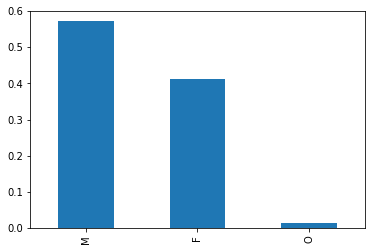

In [19]:
profile.gender.value_counts(normalize=True).plot(kind="bar");

There are more male customers (57%) than female (41%) but not that much. A bit more than 1% are unspecified.

Let's decribe the `age` data.

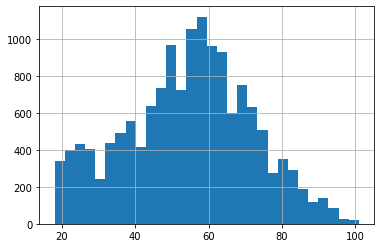

In [20]:
profile.age.hist(bins=30);

In [21]:
profile.age.mean(), profile.age.median(), profile.age.mode()[0]

(54.39352445193929, 55.0, 58.0)

Age has normal distribution (symmetrical), mostly from 50's to 60's. It's also inline with the global statistics. (https://www.statista.com/statistics/250091/coffee-drinking-consumers-in-the-us-by-age-group-2010/)

Expanding our analysis on age, we can look at the age groups.

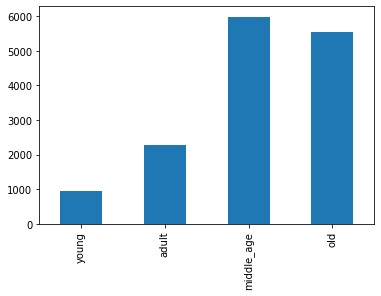

In [22]:
profile_age = profile.copy()
profile_age["group"] = pd.cut(profile_age.age, bins=[18, 25, 40, 60, 101], labels=["young", "adult", "middle_age", "old"])

profile_age.group.value_counts().sort_index(axis=0).plot(kind="bar");

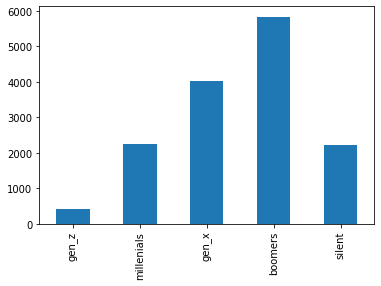

In [23]:
year = 2018

profile_age["generation"] = pd.cut( \
    profile_age.age, \
    bins=[18, year-1997, year-1981, year-1965, year-1946, 101], \
    labels=["gen_z", "millenials", "gen_x", "boomers", "silent"] \
)

profile_age.generation.value_counts().sort_index(axis=0).plot(kind="bar");

It's really noticeable that as you grow older, you like coffee more. The graphs shows that `middle_age` adult and `boomers` (40-60) are the ones mostly who likes coffee.

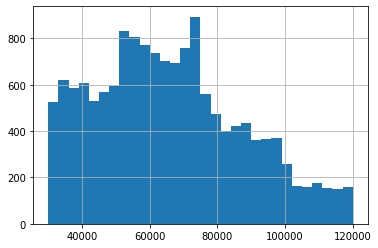

In [24]:
profile.income.hist(bins=30);

In [25]:
profile.income.mean(), profile.income.median(), profile.income.mode()[0]

(65404.9915682968, 64000.0, 73000.0)

Income distribution is right-skewed. This is true, since having Starbucks coffee appeals more to premium customers.

Next is the membership date. This is perhaps one of the important information we can focus more. Becoming a member, means we can get more customer profile and we can fine tune further our offers later.

In [26]:
profile.became_member_on.dt.year.value_counts(normalize=True)

2017    0.380529
2018    0.246941
2016    0.207412
2015    0.107647
2014    0.040647
2013    0.016824
Name: became_member_on, dtype: float64

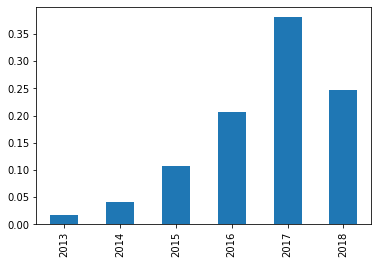

In [27]:
profile.became_member_on.dt.year.value_counts(normalize=True).sort_index(axis=0).plot(kind="bar");

In [28]:
profile.became_member_on.dt.month.value_counts(normalize=True)

8     0.094706
10    0.092235
12    0.091529
1     0.089706
9     0.089118
11    0.085235
7     0.079941
3     0.078176
4     0.077353
5     0.076882
6     0.074412
2     0.070706
Name: became_member_on, dtype: float64

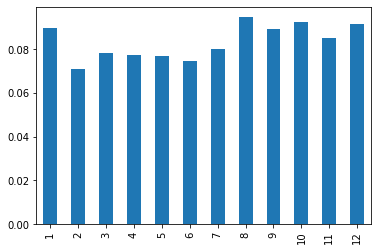

In [29]:
profile.became_member_on.dt.month.value_counts(normalize=True).sort_index(axis=0).plot(kind="bar");

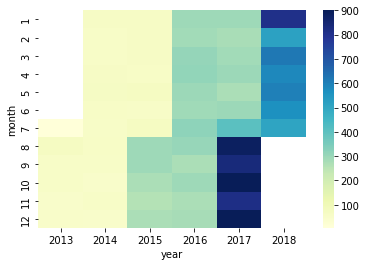

In [30]:
profile_date = profile.copy()
profile_date["month"] = profile.became_member_on.dt.month
profile_date["year"] = profile.became_member_on.dt.year

sns.heatmap( \
    profile_date \
        .groupby(by=["year", "month"]) \
        .became_member_on \
        .count() \
        .reset_index() \
        .pivot("month", "year", "became_member_on"), \
    cmap="YlGnBu" \
);

Membership dates from early 2013 to mid 2018. The data did not show however, if the offer started along those dates. We'll note that for now.

Most joiners are during 2017 (38%), and we've seen membership growth trends which only dip in 2018. New joiners are distributed almost equally on different months.

There's also burst of joiners from August 2017 to January 2018.

#### Bivariate and Multivariate

Let's start first with how `gender` distribution with `age`.

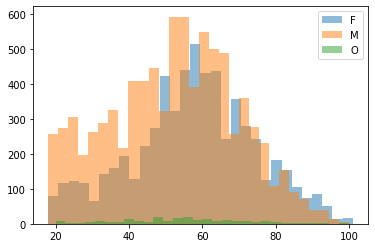

In [31]:
for g in profile.gender.dropna().unique():
    plt.hist(profile[profile.gender == g].age, bins=30, alpha=0.5, label=g)

plt.legend()
plt.show()

The normal distribution is more visible with `Female`, but visually, the peaks are still the same with `male`.

On the topic of `gender`, let's look closely its distribution with `income`.

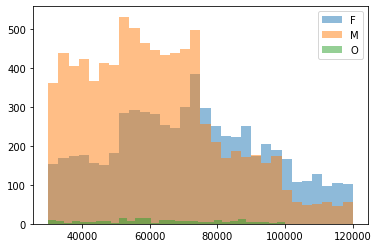

In [32]:
for g in profile.gender.dropna().unique():
    plt.hist(profile[profile.gender == g].income, bins=30, alpha=0.5, label=g)

plt.legend()
plt.show()

Again the distribution is more normal with `Female` customers, and the peak is still the same. This also means that at lower income bracket, men are more likely to spend more than women.

Now, let's see the distribution of gender for each year.

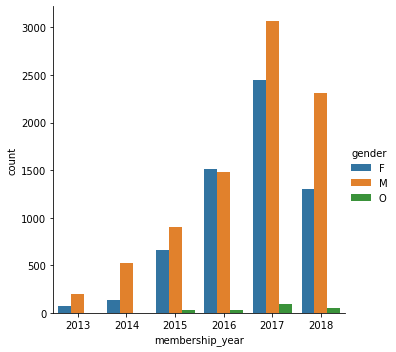

In [33]:
profile_date = profile.copy()
profile_date["membership_year"] = profile_date.became_member_on.dt.year
profile_date["membership_month"] = profile_date.became_member_on.dt.month

sns.catplot(data = profile_date, kind="count", x="membership_year", hue="gender", ci=None);

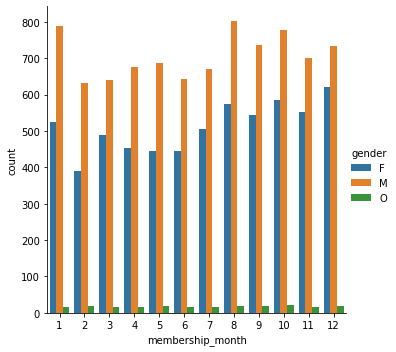

In [34]:
sns.catplot(data = profile_date, kind="count", x="membership_month", hue="gender", ci=None);

A bit consistent with what we've seen so far. On the yearly membership view, `Female` customers consistently caught up from 2013 to 2016, after that `Male` coffee drinkers took a huge growth in 2017 and 2018.

Moving on from gender, let's understand better the relationship of age and income.

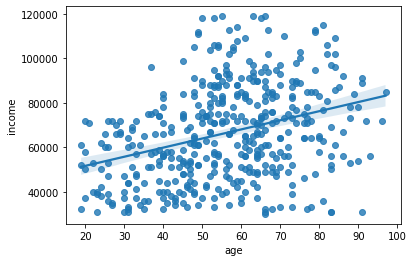

In [35]:
profile_sub = profile_age.sample(frac=0.03, random_state=42)

sns.regplot(data = profile_sub, x="age", y="income");

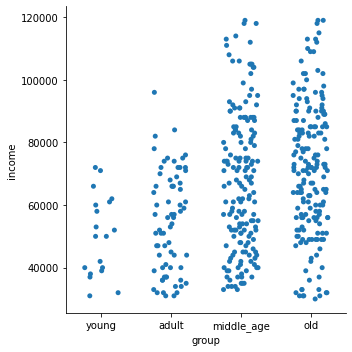

In [36]:
sns.catplot(data = profile_sub, x="group", y="income", jitter=0.25, color=base_color);

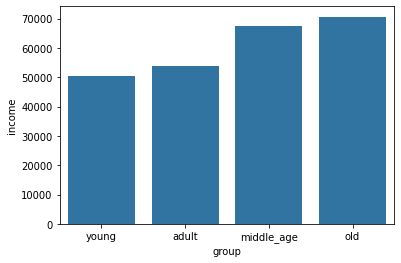

In [37]:
sns.barplot( \
    data=profile_age.groupby("group").income.mean().reset_index(), \
    x="group", \
    y ="income", \
    ci=None, \
    color=base_color);

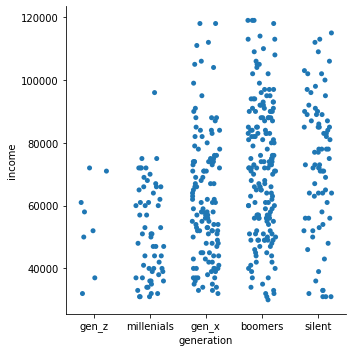

In [38]:
sns.catplot(data = profile_sub, x="generation", y="income", jitter=0.25, color=base_color);

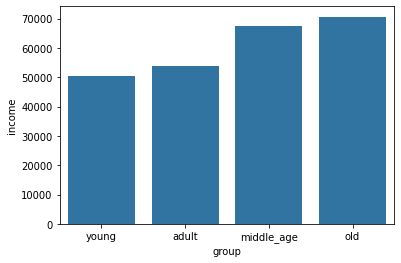

In [39]:
sns.barplot( \
    data=profile_age.groupby("group").income.mean().reset_index(), \
    x="group", \
    y ="income", \
    ci=None, \
    color=base_color);

We can see a small trend that as customer age, there's an increase in income. However, the points are too scattered from the mean. It also validates, that from `middle_age` or `gen_x` have higher range of income.

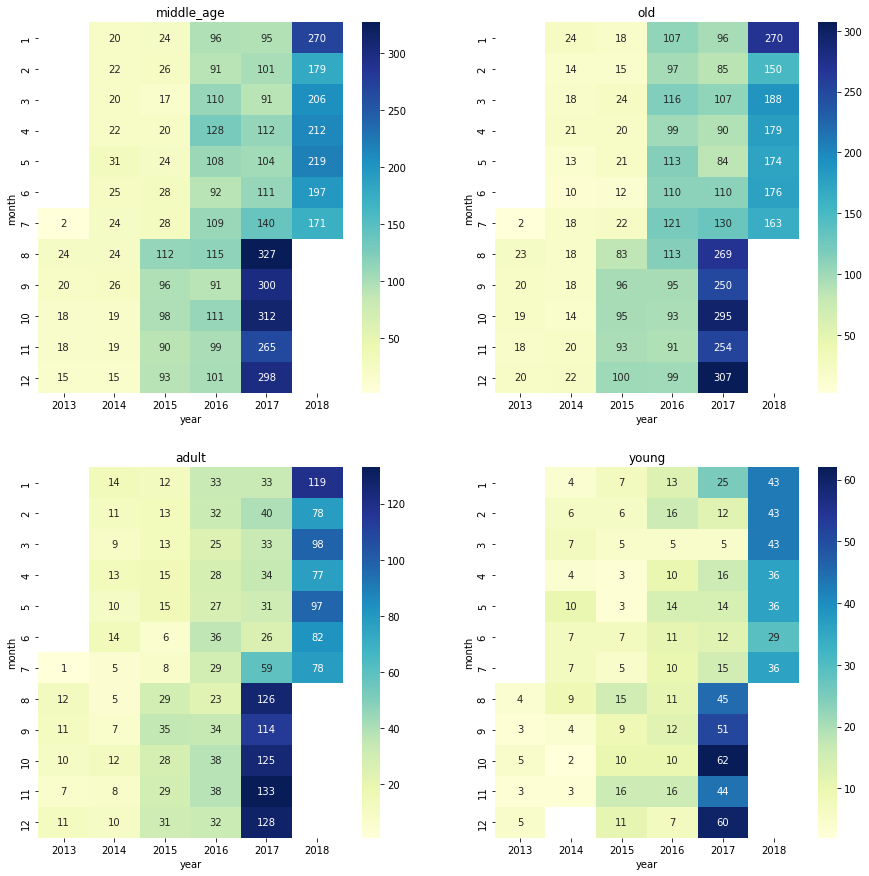

In [40]:
profile_age_date = profile_age.copy()
profile_age_date["month"] = profile_age_date.became_member_on.dt.month
profile_age_date["year"] = profile_age_date.became_member_on.dt.year

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
index = 0

for gr in profile_age_date.group.dropna().unique():
    a = axes[index // 2, index % 2]
    a.set_title(gr)

    sns.heatmap( \
        profile_age_date[profile_age_date.group==gr] \
            .groupby(by=["year", "month"]) \
            .became_member_on \
            .count() \
            .reset_index() \
            .pivot("month", "year", "became_member_on"),\
        annot=True, \
        fmt="g", \
        cmap="YlGnBu", \
        ax=a
    )

    index = index + 1


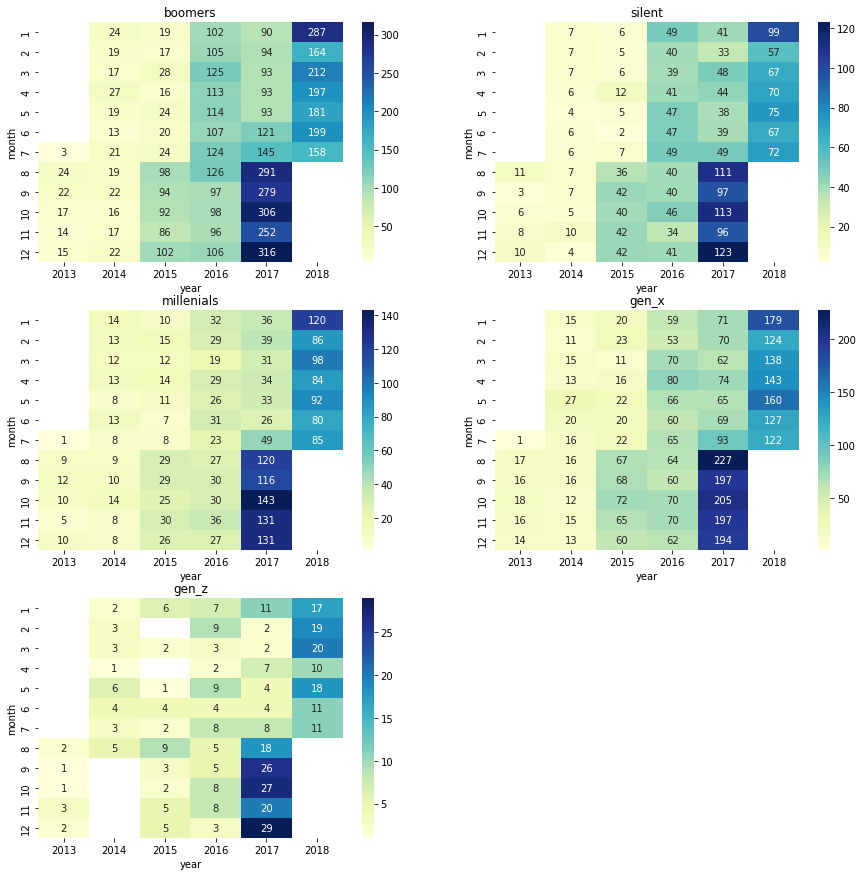

In [41]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
index = 0

for gn in profile_age_date.generation.dropna().unique():
    a = axes[index // 2, index % 2]
    a.set_title(gn)

    sns.heatmap( \
        profile_age_date[profile_age_date.generation==gn] \
            .groupby(by=["year", "month"]) \
            .became_member_on \
            .count() \
            .reset_index() \
            .pivot("month", "year", "became_member_on"),\
        cmap="YlGnBu", \
        fmt="g", \
        annot=True, \
        ax=a
    )

    index = index + 1

fig.delaxes(ax=axes[2, 1])

It's consistent, the registration burst from August 2017 to January 2018, but now it's more visible that most of those who registered are `boomers`/`middle_age`.

### Understand Transcript Table

The transcript table will be the main table we'll be looking it. It contains offer events or normal transactions. Let's try to dissect it to gain further understanding on this table. Few things I want to understand, how are events sequenced. Also, how are the data structured per events.

#### Univariate

In [42]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   person_id  306534 non-null  int64   
 1   event      306534 non-null  category
 2   time       306534 non-null  int64   
 3   offer_id   306534 non-null  category
 4   amount     138953 non-null  float64 
 5   reward     33579 non-null   float64 
dtypes: category(2), float64(2), int64(2)
memory usage: 9.9 MB


In [43]:
transcript.describe(include="all")

,person_id,event,time,offer_id,amount,reward
count,306534.000000,306534,306534.000000,306534.0,138953.000000,33579.000000
unique,NaN,4,NaN,11.0,NaN,NaN
top,NaN,transaction,NaN,0.0,NaN,NaN
freq,NaN,138953,NaN,138953.0,NaN,NaN
mean,8501.102374,NaN,366.382940,NaN,12.777356,4.904137
std,4901.913992,NaN,200.326314,NaN,30.250529,2.886647
min,1.000000,NaN,0.000000,NaN,0.050000,2.000000
25%,4265.000000,NaN,186.000000,NaN,2.780000,2.000000
50%,8499.000000,NaN,408.000000,NaN,8.890000,5.000000
75%,12731.000000,NaN,528.000000,NaN,18.070000,5.000000


Here are few notable observations.

* `offer_id`, `amount` and `reward`, has different values depending on events. 
* The most top events in the data is of type `transaction`.
* Since `time` is "hours since start of test", therefore the time value here is just the timeline duration of individual test. Let's try to dig more on this later.
* Longest `time` duration for the test id 714 hours (~30 days). Average at 366 hours (~15 days).
* `amount`'s max is 1062.28, that's a big amount, let's check if it's an outlier. On the other side of spectrum, the minimum amount value is 0.05. We need more information to understand as to why.
* Most items in the transcript are of "not given offer" type (0).
* `reward` range from 2 - 10, averaging at 5.
* All in all, the event data are complete, and the missing ones are because different events have different data under `amount` and `reward`.

Let's drill down first at `event` feature.


In [44]:
transcript.event.value_counts(normalize=True)

transaction        0.453304
offer_received     0.248837
offer_viewed       0.188315
offer_completed    0.109544
Name: event, dtype: float64

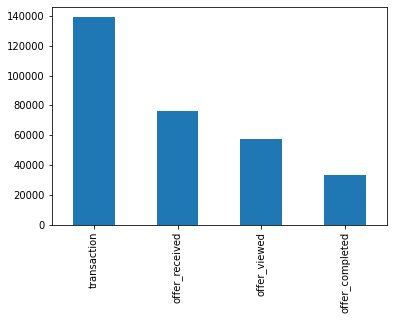

In [45]:
transcript.event.value_counts().plot(kind="bar");

In [46]:
trans_events = transcript.event \
    .apply(lambda x: False if x != "transaction" else True) 

trans_events.value_counts(normalize=True)

False    0.546696
True     0.453304
Name: event, dtype: float64

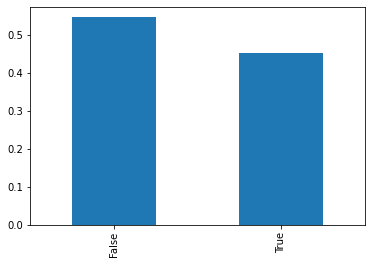

In [47]:
trans_events.value_counts(normalize=True).plot(kind="bar");

Event distribution in `transcript` table shows that `transaction` or "no offer" is still the top data at 45%. Combining offer events, they occupy 55% of the data, while not offered events is at 45%.

Next we're going to try to understand is time.

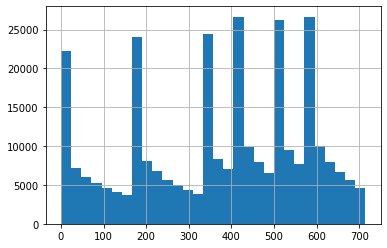

In [48]:
transcript.time.hist(bins=30);

There are some noticeable spikes in the distribution. Dividing the estimated value of the spikes, they coincide with 0, **7**, **14**, 17, **21**, 24. The **bold** ones are week timeframes. Let's take note of that for now. Also, lot of events happening on the third week.

Moving to `offer_id`.

In [49]:
transcript.offer_id.value_counts(normalize=True).sort_index(axis=0)

0     0.453304
1     0.058923
2     0.059445
3     0.038368
4     0.052855
5     0.044860
6     0.065699
7     0.066032
8     0.046667
9     0.062411
10    0.051436
Name: offer_id, dtype: float64

With large difference of `transaction` events, let's remove it to get a better view at the data.

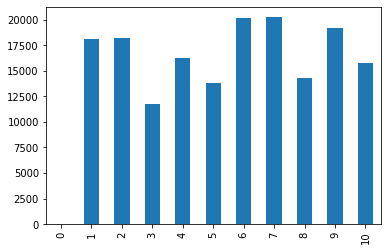

In [50]:
transcript[transcript.offer_id != 0].offer_id.value_counts().sort_index(axis=0).plot(kind="bar");

There are offers more than the others. This can be indication how consumers react to to the test or offer.

Let's move on to the `amount` and `reward`.

           bins    count
0      0.050000    816.0
1      0.093202    811.0
2      0.173732   1738.0
3      0.323842   3810.0
4      0.603653   7341.0
5      1.125231  12763.0
6      2.097471  17481.0
7      3.909761  18312.0
8      7.287935  24413.0
9     13.584974  37258.0
10    25.322882  13437.0
11    47.202765    257.0
12    87.987657    135.0
13   164.012167     69.0
14   305.724596    166.0
15   569.881675    146.0
16  1062.280000      NaN


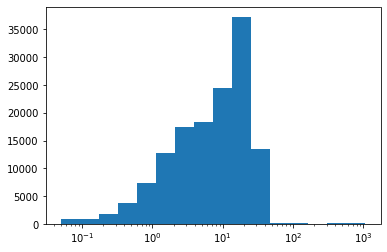

In [51]:
def plot_loghist(x, bins):
  _, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

  hist = pd.concat([pd.Series(logbins, name="bins"), pd.Series(np.histogram(x, bins=logbins)[0], name="count")], axis=1)
  print(hist)

  plt.hist(x, bins=logbins)
  plt.xscale('log')

plot_loghist(transcript[~transcript.amount.isna()].amount, 16)

We had to create a logarithmic histogram as there are super large values that can be considered outliers. The graph is a bit left skewed distribution with its peak at approximately 10 - 50 values.

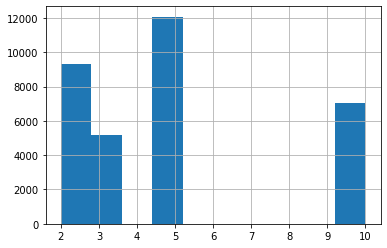

In [52]:
transcript.reward.hist();

Rewards are a bit conservative at most of them are at less than 5. The most expensive is at 10.

#### Bivariate and Multivariate

Let's understand further how `time` and `offer_id` works. Let's visually investigate on some random person.

In [53]:
transcript[transcript.person_id == 106].sort_values(["offer_id", "time"])

,person_id,event,time,offer_id,amount,reward
1426,106,transaction,198,0,22.49,NaN
1429,106,transaction,210,0,18.33,NaN
1430,106,transaction,252,0,11.80,NaN
1431,106,transaction,294,0,13.04,NaN
1433,106,transaction,342,0,12.34,NaN
1436,106,transaction,360,0,13.08,NaN
1437,106,transaction,402,0,15.26,NaN
1439,106,transaction,426,0,26.91,NaN
1440,106,transaction,456,0,25.31,NaN
1441,106,transaction,480,0,25.09,NaN


In [54]:
transcript[transcript.person_id == 106].sort_values("time")

,person_id,event,time,offer_id,amount,reward
1422,106,offer_received,0,7,NaN,NaN
1423,106,offer_viewed,96,7,NaN,NaN
1424,106,offer_received,168,7,NaN,NaN
1425,106,offer_viewed,180,7,NaN,NaN
1426,106,transaction,198,0,22.49,NaN
1427,106,offer_completed,198,7,NaN,2.0
1428,106,offer_completed,198,7,NaN,2.0
1429,106,transaction,210,0,18.33,NaN
1430,106,transaction,252,0,11.80,NaN
1431,106,transaction,294,0,13.04,NaN


In [55]:
transcript[transcript.duplicated(subset=["person_id", "event", "offer_id", "time"], keep=False)].head(10)

,person_id,event,time,offer_id,amount,reward
1427,106,offer_completed,198,7,NaN,2.0
1428,106,offer_completed,198,7,NaN,2.0
1555,111,offer_completed,480,10,NaN,2.0
1556,111,offer_completed,480,10,NaN,2.0
3110,233,offer_completed,564,1,NaN,10.0
3111,233,offer_completed,564,1,NaN,10.0
3416,251,offer_completed,426,2,NaN,10.0
3417,251,offer_completed,426,2,NaN,10.0
6617,477,offer_completed,510,1,NaN,10.0
6618,477,offer_completed,510,1,NaN,10.0


In [56]:
transcript[transcript.event == "transaction"].duplicated(subset=["person_id", "time"]).sum()

0

Here are more information regarding the events.
* `transaction` events are always `offer_id` 0
* `transaction` `time` does not reset
* `time` continuously move for each customer.
* `offer_completed` can be occur before `offer_viewed`
* a person can receive the same type of offer multiple times.
* `transaction` are compound, can an offer be included or not

With this assumptions, these are the different customer interactions.
* Customer buys a coffee with no associated offer (`transaction` with no connected `offer_completed`)
* Customer receives an offer and ends there (only event for a customer is `offer_received`)
* Customer receives an offer, viewed it but did not do anything about it (`offer_received` and `offer_viewed` only)
* Customer received, viewed and finally avail the offer (`offer_received`, `offer_viewed`, `transaction` and `offer_completed`)
* Customer availed the offer without receiving nor viewing it (`offer_received`, `transaction` and `offer_completed`)

We can extract more data if we can create an offer group. This requires a bit of coding, so we'll follow the following logic:

* Iterate through the events in order of time
* If the event is `offer_received`, create a new offer group
* If the event is `offer_viewed`, add the event to the first offer group
* if the event is `offer_completed`, add the event to the first offer group
* There could only be one of these events in every group.

In [57]:
def get_offer_group(user_group):
    offer_groups = {}
    offer_idx = 0

    for i, row in user_group.iterrows():
        if row.event == "offer_received":
            offer_idx = offer_idx + 1
            group_id = f"{offer_idx}:{row.offer_id}"

            offer_groups[group_id] = ["offer_received"]
            user_group.loc[i, "offer_group"] = offer_idx

        elif row.event == "offer_viewed":
            idx, group_id = find_offer_index(offer_groups, "offer_viewed", row.offer_id)

            offer_groups[group_id].append("offer_viewed")
            user_group.loc[i, "offer_group"] = idx
        elif row.event == "offer_completed":
            idx, group_id = find_offer_index(offer_groups, "offer_completed", row.offer_id)

            offer_groups[group_id].append("offer_completed")
            user_group.loc[i, "offer_group"] = idx
        else:
            user_group.loc[i, "offer_group"] = 0

    return user_group

def find_offer_index(offer_groups, event, offer_id):
    for group_id in offer_groups:
        idx, id = group_id.split(":")

        if (int(id) == offer_id) and (event not in offer_groups[group_id]):
            return int(idx), group_id

    return 0, None

In [58]:
def map_event_to_desc(event_seq):
    seq = ",".join(event_seq)

    if seq == "offer_received,offer_viewed,offer_completed":
        return "success"
    elif seq == "offer_received,offer_viewed":
        return "failed_viewed"
    elif (seq == "offer_received,offer_completed") or (seq == "offer_received,offer_completed,offer_viewed"):
        return "success_without_offer"
    elif seq == "offer_received":
        return "failed"
    else:
        return None


In [59]:
transcript_group = transcript.groupby("person_id").apply(get_offer_group)

In [60]:
transcript_seq = transcript_group[transcript_group.event != "transaction"] \
    .groupby(["person_id","offer_group"]) \
    .agg({"event": lambda x: x.tolist(), "offer_id": lambda x: x.iloc[0]}) \
    .reset_index()

transcript_seq.head()

,person_id,offer_group,event,offer_id
0,1,1.0,"[offer_received, offer_viewed]",10
1,1,2.0,"[offer_received, offer_viewed]",5
2,1,3.0,"[offer_received, offer_viewed, offer_completed]",7
3,1,4.0,"[offer_received, offer_viewed, offer_completed]",6
4,1,5.0,"[offer_received, offer_viewed]",7


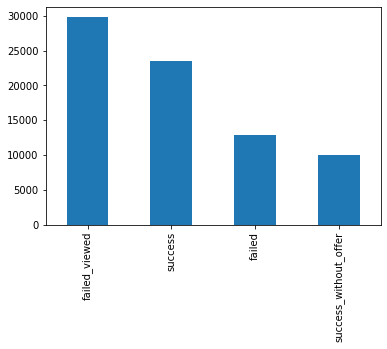

In [61]:
transcript_seq["success_message"] = transcript_seq.event.apply(map_event_to_desc)
transcript_seq.success_message.value_counts().plot(kind="bar");

In [62]:
transcript_seq["success"] = transcript_seq.event.apply(lambda x: "offer_completed" in x)

transcript_seq.success.value_counts(normalize=True)

False    0.559776
True     0.440224
Name: success, dtype: float64

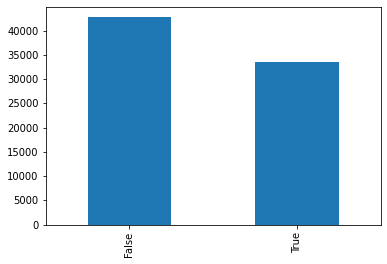

In [64]:
transcript_seq.success.value_counts().plot(kind="bar");

Here we can now see the general success of the offers.

* `success` - the offer was received, viewed and completed
* `success_without_offer` - the offer was received and not viewed, but still completed
* `failed` - the offer was received, not viewed and not completed
* `failed_viewed` - the offer was received and viewed, but not completed

As we can see at the graphs above, we have more failed offers (56%) than successful ones (44%). In the breakdown, most of the failed offers are `failed_viewed` type.

> NOTE

> We can target later to predict not giving offer to `success_without_offer`, `failed` and `failed_viewed` types.

Next we can look at the distribution of `amount` mean per person. This is to view the spending capability of each person.

          bins   count
0     0.050000     4.0
1     0.088348     7.0
2     0.156109    11.0
3     0.275839    33.0
4     0.487399    94.0
5     0.861219   472.0
6     1.521746  2314.0
7     2.688876  3332.0
8     4.751158   876.0
9     8.395144  2422.0
10   14.833950  5459.0
11   26.211115  1295.0
12   46.314201   123.0
13   81.835710   100.0
14  144.601080    27.0
15  255.505478     8.0
16  451.470000     NaN


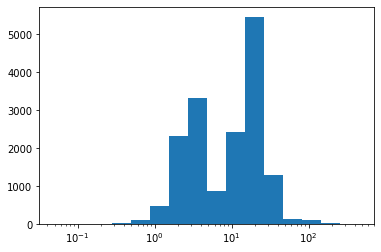

In [65]:
plot_loghist(transcript[~transcript.amount.isna()].groupby("person_id").amount.mean(), 16)

As we can see here, there's spike in average amount `2` and `10` per person. We can use this information to guide us when creating offers in the future.

Let's try to look at the reward distribution as well.

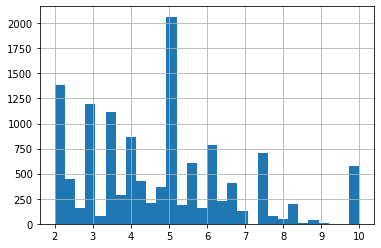

In [66]:
transcript[~transcript.reward.isna()].groupby("person_id").reward.mean().hist(bins=30);

Most reward availed in average per person is at `5`. This coincide with one of the `bogo` offers.

Let's move and take a look at the success rate of each offer.

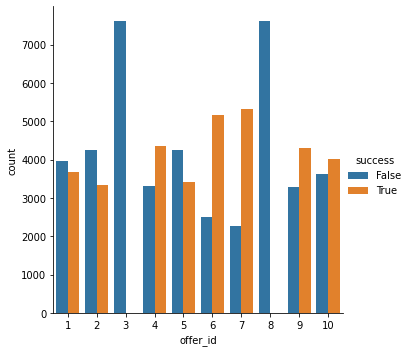

In [67]:
sns.catplot(data = transcript_seq, x="offer_id", hue="success", kind="count");

In [68]:
transcript_seq.groupby("offer_id").success.apply(lambda x: sum(x)/len(x))

offer_id
1     0.481588
2     0.438694
3     0.000000
4     0.567149
5     0.446009
6     0.674340
7     0.699882
8     0.000000
9     0.567428
10    0.526336
Name: success, dtype: float64

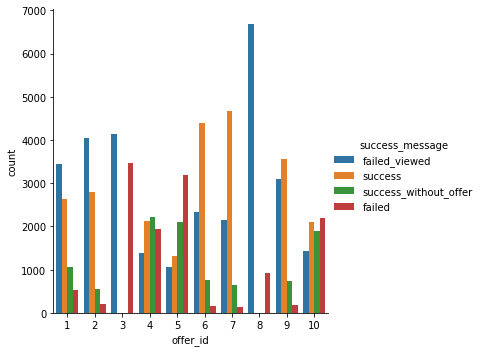

In [69]:
sns.catplot(data = transcript_seq, x="offer_id", hue="success_message", kind="count");

This is an interesting information here. Offers 3 and 8 are 100% failure. While offers 6,7 have the highest success rate at 67% and 70% respectively. These are both of type `discount`.